In [123]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras import backend as K
import numpy as np

Using TensorFlow backend.


In [164]:
# Define path to the data directory
data_dir = Path('Desktop/covid_19/X_rays_VS_No_X_rays')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [128]:
types = ('*.jpg', '*.jpeg') # the tuple of file types


In [130]:
# dimensions of our images.
img_width, img_height = 150, 150

In [131]:
train_data_dir = 'Desktop/covid_19/X_rays_VS_No_X_rays/train'
validation_data_dir = 'Desktop/covid_19/X_rays_VS_No_X_rays/val'
test_data_dir = 'Desktop/covid_19/X_rays_VS_No_X_rays/test'

nb_train_samples = 5217
nb_validation_samples = 17
epochs = 20
batch_size = 16

In [132]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [133]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [134]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2150 images belonging to 2 classes.


In [135]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 126 images belonging to 2 classes.


In [136]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 634 images belonging to 2 classes.


In [140]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Create Sequential model

In [141]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

### Check information about model

In [142]:
model.layers

In [143]:
model.input

<tf.Tensor 'conv2d_1_input:0' shape=(None, 150, 150, 3) dtype=float32>

In [144]:
model.output

<tf.Tensor 'activation_5/Sigmoid:0' shape=(None, 1) dtype=float32>

In [145]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Fit Model

In [146]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
326/326 [==============================] - 125s 385ms/step - loss: 0.1275 - accuracy: 0.9583 - val_loss: 0.5296 - val_accuracy: 0.9375
Epoch 2/20
326/326 [==============================] - 119s 364ms/step - loss: 0.1262 - accuracy: 0.9856 - val_loss: 1.0960e-05 - val_accuracy: 1.0000
Epoch 3/20
326/326 [==============================] - 119s 366ms/step - loss: 0.1034 - accuracy: 0.9911 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 4/20
326/326 [==============================] - 129s 395ms/step - loss: 0.0420 - accuracy: 0.9915 - val_loss: 2.0153e-06 - val_accuracy: 1.0000
Epoch 5/20
326/326 [==============================] - 128s 393ms/step - loss: 0.0876 - accuracy: 0.9927 - val_loss: 4.0225e-13 - val_accuracy: 1.0000
Epoch 6/20
326/326 [==============================] - 115s 353ms/step - loss: 0.0678 - accuracy: 0.9929 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 7/20
326/326 [==============================] - 128s 393ms/step - loss: 0.1199 - accuracy: 0.9892 - val_lo

### Save model`s weights

In [147]:
model.save_weights('first_try.h5')

In [148]:
# evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 98.90%


In [159]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

# Checking

In [191]:
test_data_dir = Path('Desktop/covid_19/X_rays_VS_No_X_rays/test')


In [192]:
# Path to test directory
test_dir_xrays = test_data_dir / 'xrays'
test_dir_no_xrays = test_data_dir / 'no_xrays'

In [193]:
# Get the list of all the images
no_xrays = test_dir_no_xrays.glob('*.jpg')

xrays = test_dir_xrays.glob('*.jpg')
xrays1 = test_dir_xrays.glob('*.jpeg')

In [187]:
from keras.utils import to_categorical


In [194]:
test_data = []
test_labels = []

for img in no_xrays:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150,150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in xrays:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150,150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (359, 150, 150, 3)
Total number of labels: (359, 2)


In [197]:
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(359,)
(359,)


<Figure size 432x288 with 0 Axes>

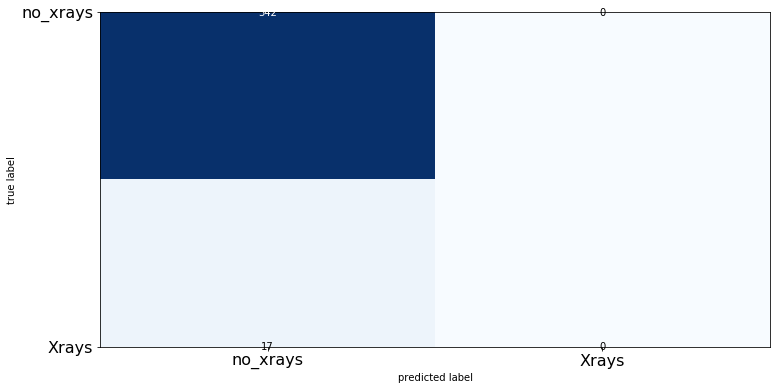

In [214]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['no_xrays', 'Xrays'], fontsize=16)
plt.yticks(range(2), ['no_xrays', 'Xrays'], fontsize=16)
plt.show()

In [213]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.00
Precision of the model is nan


/Users/anastasia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
